<a href="https://colab.research.google.com/github/NurikS/Fraud-Detection/blob/master/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection
### In this notebook, we will try to create an algorithm to identify fraud transactions.

First, as usual, install and import all the dependencies

In [4]:
!pip install kaggle

In [0]:
import os
os.environ["KAGGLE_USERNAME"] = "nurbeks"
os.environ["KAGGLE_KEY"] = "5975c07db9c271e62bf0070d5c686d2e"

In [3]:
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip sample_submission.csv.zip

Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train_identity.csv.zip
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  test_identity.csv.zip
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import numpy as np                                       #Linear Algera
import pandas as pd                                      #Data manipulation
import matplotlib.pyplot as plt                          #Data visualizations
import seaborn as sns
from sklearn.linear_model import LogisticRegression      #Model

In [0]:
train_transactions = pd.read_csv("train_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")
test_transactions = pd.read_csv("test_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")

sample_submission = pd.read_csv("sample_submission.csv")

In [0]:
train = pd.merge(train_transactions, train_identity, on="TransactionID", how="left")
test = pd.merge(test_transactions, test_identity, on="TransactionID", how="left")

In [8]:
print(f"Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [9]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [11]:
print(f"There are {train.isnull().any().sum()} columns in train dataset with missing values.")

There are 414 columns in train dataset with missing values.


In [12]:
train_identity.describe(include=["object", "float64", "int64"])

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,144233,127320.000000,80044.000000,140985,129340,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,5169,4747.000000,5132.000000,5163.000000,5169,140978,140978,77565,140282,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2,2,2,75,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,NaN,IP_PROXY:TRANSPARENT,NaN,NaN,NaN,Found,Found,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,NaN,3489,NaN,NaN,NaN,5155,76232,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,NaN,48.053071,-344.507146,NaN,NaN,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,NaN,12.800927,329.608924,149.070308,NaN,NaN,NaN,NaN,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,NaN,11.774858,93.695502,NaN,NaN,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,NaN,2.372447,97.461089,32.101995,NaN,NaN,NaN,NaN,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,NaN,10.000000,-660.000000,NaN,NaN,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,NaN,11.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,0.000000,100.000000,NaN,49.000000,-360.000000,NaN,NaN,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,NaN,11.000000,321.000000,119.000000,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,0.000000,100.000000,NaN,52.000000,-300.000000,NaN,NaN,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,NaN,11.000000,321.000000,149.000000,NaN,NaN,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,0.000000,100.000000,NaN,52.000000,-300.000000,NaN,NaN,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,NaN,15.000000,371.000000,169.000000,NaN,NaN,NaN,NaN,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
del train_transactions, train_identity, test_transactions, test_identity

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of id_01 var')

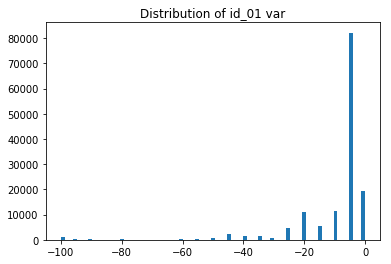

In [14]:
plt.hist(train["id_01"], bins=77)
plt.title("Distribution of id_01 var")

In [15]:
len(train[train["isFraud"]==1])/len(train)*100

3.4990009144173126

In [0]:
n_columns = pd.DataFrame({"na_count": train.isnull().sum().sort_values(ascending=False)})

In [0]:
n_columns["per"] = n_columns["na_count"]/len(train)

In [18]:
range = [0.05, 0.1, 0.15, 0.25, 0.4]

for i in range:
  print(n_columns[n_columns["per"]<i].shape[0]/train.shape[1])

0.25806451612903225
0.25806451612903225
0.3686635944700461
0.41935483870967744
0.46543778801843316


In [0]:
limit = 0.1

final_columns = n_columns[n_columns["per"]<limit].index

train = train[train.columns.intersection(final_columns)]

In [20]:
train[train.select_dtypes(include=["object"]).columns]

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit
5,W,visa,debit
6,W,visa,debit
7,W,visa,debit
8,H,visa,debit
9,W,mastercard,debit


In [0]:
card6_dummy = pd.get_dummies(train["card6"])

In [0]:
train = pd.concat([train, card6_dummy], axis=1)

In [23]:
train = train._get_numeric_data()
train = train.dropna()
len(train[train["isFraud"]==1])/len(train)*100

3.46278261170406

In [0]:
X = train.drop(["isFraud"], axis=1)
y = train["isFraud"]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

In [29]:
LinearClassifier = LogisticRegression(solver="lbfgs")
LinearClassifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
LinearClassifier.score(X_test, y_test)

0.9656065664515906

In [0]:
y_preds = LinearClassifier.predict(X_test)

In [33]:
recall_score(y_test, y_preds)

0.0

Now, we see that the imbalance in the dataset caused this overfit. We have learned too much of the negative class. That is why our accuracy score is so high, but in this particular case, we care more about recall. To solve this, we need to balance our dataset out.

In [34]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 3.5MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [36]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print("New shape of the train set is :", X_res.shape)
print("New shape of the test set is :", y_res.shape)

New shape of the train set is : (40036, 112)
New shape of the test set is : (40036,)


In [40]:
from collections import Counter

print("New data distribution looks like this:", Counter(y_res))

New data distribution looks like this: Counter({0: 20018, 1: 20018})


In [0]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size = 0.4)

In [42]:
LinearClassifier.fit(X_res_train, y_res_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_res_preds = LinearClassifier.predict(X_res_test)

In [45]:
recall_score(y_res_test, y_res_preds)

0.5535490343616755

In [46]:
LinearClassifier.score(X_res_test, y_res_test)

0.5264439587886357

In [48]:
pd.crosstab(y_res_test, y_res_preds, rownames=["True"], colnames=["Predicted"], margins=True)

Predicted,0,1,All
True,,,
0,4017,4024,8041
1,3560,4414,7974
All,7577,8438,16015


Now, we've got higher performance, but we still have room for improvement. We could incorporate unused categorical variables or use other classification methods (Gradient Boosting and Neural Nets).